In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pylab as plt
import operator
import copy
import utils

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.width', 2000)

In [3]:
sys.version

'3.6.6 (default, Jul 19 2018, 14:25:17) \n[GCC 8.1.1 20180712 (Red Hat 8.1.1-5)]'

# Plan

The dataset is from Microsoft's Malware Prediction Competition on Kaggle (https://www.kaggle.com/c/microsoft-malware-prediction). There are parameters/features for multiple machines and a flag inficating whether malware was detected (1) on the machine or not (0).

The goal of this notebook and the associated scripts is to walk you through the process of exploring the data, preprocessing and building features for input into a machine learning model. Once the model is trained, we'll go over the process of tuning hyperparameters and very importantly, of inspecting the model to understand our data better. 

Lastly, we'll have some cursory treatment of ensembling or combining models to produce better performing models.

**Disclaimers**

1. There is a lot more to be said for each of the steps above but in our opinion, the best way to learn is to build as many models as possible with careful inspection.

2. We do not cover the details of each modeling technique - random forests, logistic regression, support vector machines, neural networks to name a few. There is great documentation already available and we are happy to walk through the details in person. Depending on your interests, you might want to go deep into mathematical results or just apply the algorithms. The abstractions are leaky though - one cannot treat these algorithms as black boxes which takes data in and produce outputs/predictions. Each technique makes certain assumptions and it's important to ensure the input data reflects those.

3. We want to put this workshop into a broader context:

The hardest part in industrial/applied data science is defining the problem to solve. This sounds very vague but every single company or research field for that matter, suffers from this issue. For machine learning to be relevant, the problems needs to 1) have relevant data available in reasonable quantities, 2) be operationalizable i.e. one should be able to act on the recommendations of the model, 3) have a "statistical component" to it. As a counterexample, suppose the problem is to sort arrays. Would you collect data on N (1 million) arrays i.e. input arrays and output sorted arrays and feed it to a machine learning algorithm or would you use a sorting algorithm with performance guarantees that work in every single case?

Once a problem is identified, a lot of initial effort is spent in engineering pipelines and frameworks so one can fruitfully enter the iteration loop of model development (the notebook below). The loop consists of picking the quantity to predict, deciding on a metric to evaluate how well the model does, preprocessing the data for a modeling technique and training the model, validating the model on new data and then repeating the process till one achieves acceptable performance.

Kaggle competitions only focus on the last bit of building an extremely well performing model. While in practice, one might be happy with a model that has 70% accuracy, in a competition, users will fight to increase it to 70.001%. This has resulted in several tricks and techniques to extract small gains at the cost of very complex models. We'll cover some of those techniques here (ensembling) and it's definitely a useful skill to know but often not needed.



# Read Data

#### Question: Read the data from the provided csv files. For exploration, you can use the "skiprows" argument to read in a randomly selected sample of data.

Do the following:

1. Count the number of rows and columns in the dataframe
2. Look at the first few rows of the data and specific columns
3. Print out a list of the columns

What can you say about:
1. the "MachineIdentifier" column
2. the "HasDetections" column, in particular the distribution of the values

In [ ]:
#read data
data = pd.read_csv('data/MS/train.csv')

In [ ]:
#(nrows, ncols)
data.shape

In [ ]:
#first 10 rows
data.head(10)

In [ ]:
#access column's first 10 rows
data['MachineIdentifier'].head(10)

In [ ]:
#number of unique values for each column
for col in data.columns:
    print(f'{col} : {len(data[col].unique())}')

Notes:

   * No time-stamps - technically, one would expect a sequence of events before a machine is infected but this is data is a flat snapshot.
    
   * MachineIdentifier - primary key/index
    
   * HasDetections - binary target to predict (0 - not infected, 1 - infected) 

In [ ]:
len(data['MachineIdentifier'].unique())

In [ ]:
#Distribution of target
data['HasDetections'].value_counts()

**Labels have an even distributions (~50-50%)**

The column we are predicting is often called the "label" or the "target". Targets can be of many kinds:

1. Real (float) values - such machine learning problems are called **regression** problems. Examples - predict the value of homes based on neighborhood and macroeconomic quantities, predict the angle through which a steering wheel should be turned on a self-driving car based on environment inputs.

2. Discrete values - these problems are called **classification** problems. In this case, we have two labels - 0 or 1. A key distinction from regression is that while numerically 1 > 0, in terms of class there's no meaning to the statement class 1 > class 0 and this has to get reflected in the type of model chosen. If there are two classes or categories to be predicted, the problems are often called **binary classfication** problems as opposed to **multi-class classification** problems consisting of > 2 categories. Examples - is a check fake or not based on the image, image labels based on pixels.

For binary classification problems, a concern is the balance of the two labels i.e.the % of rows with 0s with 1s. If they are roughly equally distributed, then there's no problem. But what if they are not? Let's look at an extreme example.

For many (supervised) anomaly/outlier detection problems (target = 0 is normal, target = 1 is anomalous), most of the dataset consists of 0s with very few 1s. For example - maybe 98% of the rows are normal and 2% are anomalous. Why is this a problem? Suppose we build/train a model that predicts whether a data-point (row) is normal or anomalous. But we decide to cheat - our "model" predicts every row is normal (0). What would the accuracy of such a model be?

Correct - we got all the target = 0 (98%) predictions right.

Incorrect - we got all the target = 1 (2%) predictions wrong.

So, our accuracy is 98% which sounds great but we didn't really learn the ability to predict the anomalies!!!

There are some common remedies to this *class imbalance* problem:

1. Use a different metric:

Instead of accuracy, use area under curve (see below) or look at the confusion matrix, or precision/recall curves which are all sensitive to the problem described above.

2. Resampling: 

Take all the anomalous rows and randomly sample as many rows from the normal rows. While this leads to a 50-50% label split, we dramatically reduced the size of our dataset (4% of the original). A workaround for the small dataset size is to do this procedure multiple times and train a model on each instance. The outputs from all the models is then combined in a meta-model which often leads to much better results.

Another approach is to keep the normal rows but sample with replacement from the anomalous rows. This will lead to a 50-50% split with each anomalous row repeated several times.

As with many aspects of practical machine learning, there's no procedure. What you pick depends on the problem, how various modeling techniques work, as well as sometimes just trial and error with careful checking.

3. Resampling by weights:

A very elegant approach is to apply a weight of 1 to each normal row but a much higher weight (49 = 98/2) to each anomalous row. What does this mean? Most machine learning algorithms can be recast as optimization problems where:

$C = \Sigma_{i=1}^n C[i]$

is some *cost* that is to be minimized. Each $C[i]$ is 0 when the prediction for the $i^{th}$ point agrees with the label and is high when it doesn't.

This can be modified to:

$C = \Sigma_{i=1}^n w(i) C[i]$

where $w(i)$ is a weight that is 1 for the large class (normal) and high for the small class (anomalous).

Suppose we have a simple cost function: if the prediction for the ith row is correct, $C[i] = 0$ and if it's wrong, $C[i] = 1$. Without the weights, whether we get an anomalous row prediction incorrect or a normal row prediction incorrect, our cost increases by 1.

But with the weights, if we get a normal row prediction incorrect, the cost increases by 1 but if we get an anomalous row prediction incorrect, it increases by $w(i)$ (49 in this case). This forces the algorithm to try and get the anomalous predictions correct too instead of ignoring them and focusing on the majority class of normal rows.

**Note on probabilities by scores**

For classification problems, most algorithms predict a number (**score**) between 0 and 1. It is very tempting to treat these as probabilities of belonging to target = 1 but this is often incorrect.

One way to use these scores is to use them as they are and pick a threshold (see AUC below) t, such that a score > t signifies a prediction of 1 and a score <= t signifies a prediction of 0.

In some applications though, we want to intepret the score as a probability. The act of transforming scores to probabilities is called *probability calibration*.

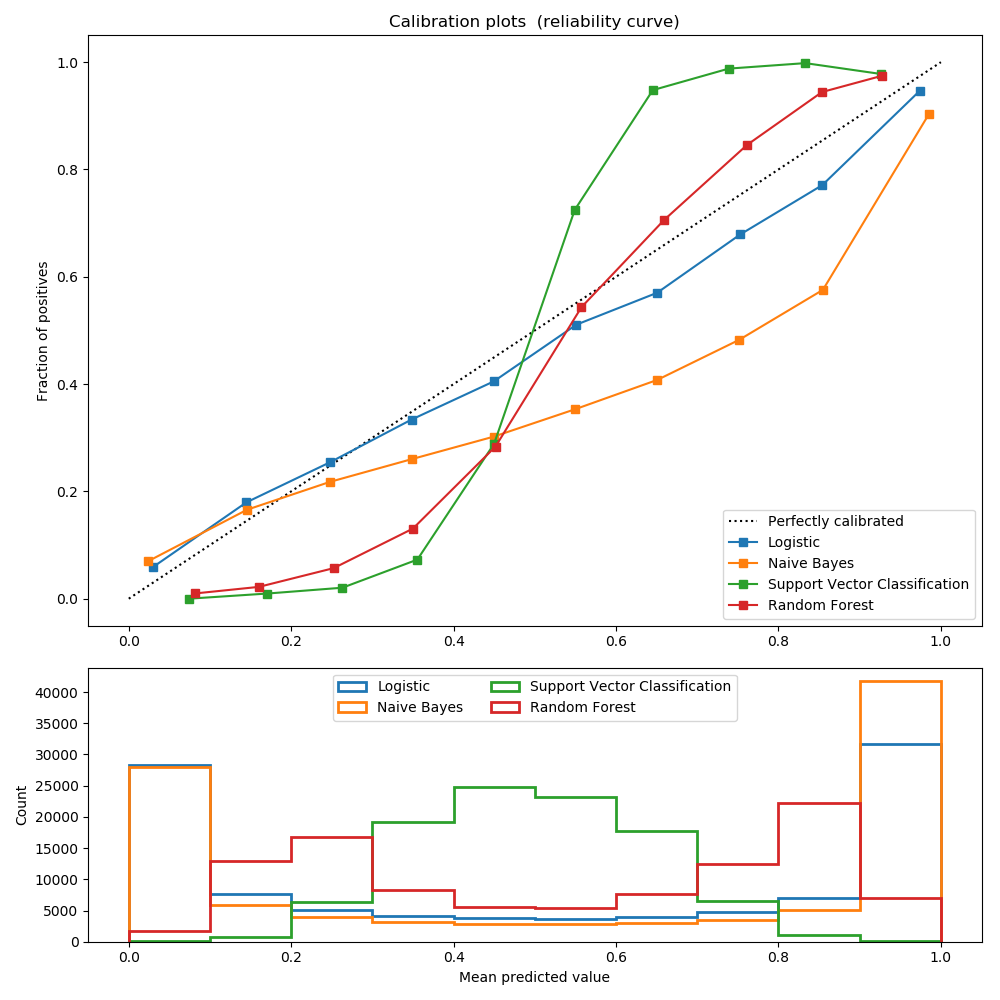
(from sklearn's documentation)

# Measuring model performance

The metric we use for this competition is "Area under ROC curve" (AUC = area under curve). This is a number between 0 and 1 where

AUC = 0.5 -> random guesses for HasDetections

AUC = 1.0 -> perfect predictions

The core idea is very simple. Suppose we have a binary classification problem with labels = 0 or 1. We build a model that predicts a score between 0 and 1 and based on some threshold, t, we want to make a hard prediction for each row. More precisely, if the score > t, prediction = 1 and if the score <= t, prediction = 0.

$\begin{array}{ c c c } 
\text{row id} & \text{score} & \text{threshold=0.45}\\ 
1 & 0.2 & 0\\
2 & 0.8 & 1 \\
3 & 0.4 & 0\\
\vdots & \vdots & \vdots \\
\end{array}$

What t should we pick? Before answering this question, let's define a **confusion matrix**.

$\begin{array}{ c c c } 
 & \text{actual 1} & \text{actual 0}\\
\text{predicted 1} & TP & FP \\
\text{predicted 0} & FN & TN\\
\end{array}$

where TP = true positive, FP = false positive, FN = false negative, TN = true negative. The names are confusing and don't matter. The crucial idea is there are two actual labels, two predicted labels, giving 4 categories and we have the number of data observations in each category.

A handy way to remember what the various acronyms are:
1. Positive and Negative always refers to the predicted category. ?P = all examples that were predicted to be positive, ?N = all examples that were predicted to be negative.

2. True and False refers to the correctness of the prediction. So TP = all examples predicted to be positive and the True refers to the fact that these were correct predictions, hence the labels were also positive.

For each threshold, we would get a table like the one above. We want as many elements on the diagonal (TP and TN) as possible and as few on the off-diagonal (FP and FN) as possible. Generally as one increases the threshold, the number of TP increase but at the cost of also increases FP.

More precisely, define two fractions:

$\text{True Positive Rate} = \frac{TP}{TP+FN}$

$\text{False Positive Rate} = \frac{FP}{FP + TN}$

In an ideal case, true positive rate would be 1 (only TP and no FN) and false positive rate would be 0 (only TN and no FP). But, there's always a tradeoff. As one increases the threshold, the true positive rate increases (good) but the false positive rate also increases (bad).

Operationally, imagine you work in a hospital and have a medical test (could be a machine learning model) that predicts the probability that an incoming patient has the flu. You want to pick a threshold and send every patient with a probability > threshold to a special ward. What threshold should you pick?

You don't know the actual values in the table above for the new patients. You only know the predicted ones. You want the maximize the % of patients who actually have the flu among the patients identified by the model. But this comes at the cost of leaking in patients who tested positive but don't actually have the flu.

Depending on your hospital's tolerance for wasted time (and cost) on patients suspected of having the flu but not actually having it, you might change the threshold. This is the information encoded by the ROC curve.

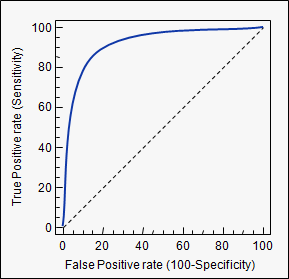

Ideally, this curve would shoot up to the top-left corner (True Positive Rate = 1 and False Positive Rate = 0) but depending on the data and the model, it'll form an arc. As you increase the threshold, you travel across this curve starting from the top-right corner (True Positive Rate = 1 and False Positive Rate = 1) when the threshold = 0 to the bottom left corner when the threshold = 1.

The area under this curve is the AUC. In the ideal case, it would be 1. If you were to make predictions by throwing a coin, it would be 0.5 (the diagonal line).

# Validation

We cannot just build a model on the train set and submit it. This usually results in overfitting i.e. a model memorizing answers instead of understanding statistical features and their relation to the output.

To guard against this, a usual practice is cross-validation.

There are a few common approaches:

**Simple splits**:

Split the data into a "train" set and a hold-out "test" set - maybe 60% is train and 40% is test. The model will be trained on the 60% and applied to the 40%. Since we know the labels (HasDetections) on both sets, we can evaluate how well we did.

**Validation set**:

The above approach has a problem. Often machine learning models have so-called hyperparameters i.e. parameters that are not optimized during fitting. Examples: linear regression with regularization have regularization strength, decision trees have tree depth (among others), neural networks have number of hidden layers, number of nodes in each layer, activation functions etc. 

We want to find the best possible model where "best" denotes the model with the highest AUC on the test set.

How would one go about this? The straighforward approach is as follows:

1. Pick a model class - say, random forests.
2. Build the model on the train set and calculate the **test AUC** by applying it to the **test** set.
3. Tweak the hyperparameters (say, number of trees) and repeat step 2 till **find maximum test AUC**.

While this approach sounds reasonable, it'll also lead to overfitting. In particular, information about the test set "leaks" into the training process and the leaker is **us**! By looking at the test AUC, we make the decision to change the hyperparameter in the new model that is trained on the train set. We'll only change the parameters when it results in a better AUC and reject the change when it results in a worse AUC. Without realizing it, we are overfitting to the test dataset.

So one will end up with excellent performance on the test set but when new data comes in, the model might suffer a drop in performance.

**Golden Rule:** No information about the test set should ever touch the training process. This is called *leakage*.

A common work-around this problem is to split the data into *3* pieces - 

**Train** set - data that the model is trained on

**Validation** set - data to which model is applied to tune the hyperparameters

**Test** set - once the final model (with the final hyperparameters) is picked, it is applied to the test set to really test performance

**k-fold Cross Validation**:

A problem with creating the validation set is that the data used for training might be severely diminished. For examples, maybe we'll choose train to be 60%, validation to be 20% and test to be 20% of the full data. Ideally, we would like to train with as much data as possible to get statistically accurate estimation of our model parameters.

A work-around this problem is **k-fold cross-validation**.

The idea is simple:

1. Split the data into k equal pieces.

2. Hold one of the pieces out and train on the remaining k-1 pieces.

3. Evaluate the performance (AUC) on the 1 piece left out.

For each piece that's left out, we'll have one AUC. So we'll eventually end up with k AUC scores. The final AUC is the average of these k AUCs.

The advantage of this approach is that we don't need a validation set and we can use more data for training. The major disadvantage is that one now needs k training loops instead of just 1.

**WARNING**: The data should be shuffled (and sklearn takes care of that) for all these splitting strategies. It is crucial to have randomly selected data in each set which results in the same probability distributions of the features in each set.

Example: we don't want to build a model to control airplane surfaces based on calm wind conditions (train set) and apply it in turbulent situations (test set). Randomization ensures that both train and test have the same mix of calm and turbulent conditions.

**WARNING**: Time-series datasets

Suppose, one has a time-series dataset i.e. one column is a timestamp. In this case, one cannot randomly sample N% of the data and declare it to be train set. The best approach is to sort by time and pick the first N% to be train and the rest to be test. In particular, each set should be continuous in time with no gaps. This is driven in large part by the fact that time-series data observations are **NOT independent**. Unlike multiple measurements in a static dataset, in time-series, each observation at time t is inextricably linked to the observations at time t-1, t-2, etc. 

As an example, consider the often attacked problem of predicting a financial time-series, say the S&P 500 index. Suppose, we have data from the year 2000 to 2019 and suppose the train data is from 2000-2010 and test is from 2011-2019. Since the index has hit values in test that were never reached in train, the distributions are fundamentally different in the two datasets. Machine learning techniques assume that the distributions are the same and they are a key assumption in theoretical results. One then has to preprocess the data to align the two distributions. A common approach is to look at percent returns ($V_t$ is the raw S&P 500 time-series):

$p_t = \frac{V_t - V_{t-1}}{V_t}$

which to a rough approximation (but not very well), results in normally distributed returns which are more similar in train and test datasets and the task is then to predict these returns. Doing such "difference" also creates measurements that are more uncorrelated i.e. $p_t$ and $p_{t-1}$ are more uncorrelated than $V_t$ and $V_{t-1}$.

#### Question: Split the data into a train and test set. For convenience, pick ~60% of the data to be the train set.

1. Persist/save the train, test sets to disk so one doesn't have to re-run this part again.
2. Check distribution of HasDetections in both the train and test sets.

In [ ]:
execute=False #so don't accidentally trigger this cell

if execute:
    train, test = train_test_split(data, train_size=0.60)

    #convert to pandas dataframes
    train = pd.DataFrame(train, columns=data.columns)
    test = pd.DataFrame(test, columns=data.columns)

    #persist dataframes so don't need to re-run splitting each time
    train.to_csv('data/cv_train.csv', index=False)
    test.to_csv('data/cv_test.csv', index=False)

In [ ]:
train = pd.read_csv('data/cv_train.csv')
test = pd.read_csv('data/cv_test.csv')

In [ ]:
print('Train:', train.shape)
print('Test :', test.shape)

In [ ]:
train['HasDetections'].value_counts()

In [ ]:
test['HasDetections'].value_counts()

# Exploratory Models

Our goal is to predict the column 'HasDetections' with the highest possible accuracy  (used loosely).

This is where 'domain knowledge' comes in. Depending on the problem, various factors and their combinations might be most meaningful. For example, while a physicist and a financial trader might both be using random forests, the input data/features will usually be hand-crafted by each one based on his/her understanding of the problem they are solving.

Having said that, statistics and machine learning models are not useful just for predicting. They can be used to gain **insight** into the data itself. We'll now start on the first leg of our journey to both predict 'HasDetections' and extract insights about what the markers for an intrusion are.

### Mutual information

We won't go into the details and derivation of mutual information here. For the purpose of this workshop, you can treat mutual information (MI) as a measure of correlation between categorical variables. Given two columns A and B, MI(A,B)=0 -> they are uncorrelated i.e. knowing the value of A says nothing about the value of B and vice-versa. A high MI(A, B) implies that knowing the value of A tells us a lot about the value of B and vice-versa.

#### Question: Compute the mutual information between the columns "SMode" and "HasDetections"

Create a dictionary that maps a column -> mutual information between this column and the target, "HasDetections"

Sort the values in decreasing order to identify the factors most likely to predict HasDetections

In [ ]:
mutual_info_score(train['SMode'], train['HasDetections'])

In [ ]:
mi_scores = {} #mutual information scores between columns and target
for col in train:
    
    try:
        score = mutual_info_score(train[col].astype(str).fillna('null'), train['HasDetections']) #MI(col, target)
        N_unique = len(train[col].unique()) #number of unique elements in col
        N_nan = np.sum(train[col].isnull())/float(train.shape[0]) #% of values that are nulls in col
    
        mi_scores[col] = (score, N_unique, N_nan)
        
    except:
        print(f'Error with col = {col}')

In [ ]:
#sort in decreasing order by MI(col, HasDetections)
for element in sorted(mi_scores.items(), key=operator.itemgetter(1, 0), reverse=True):
    print('{:50} : {:22} : {:8} : {}'.format(element[0], element[1][0], element[1][1], element[1][2]))

# Simple 1-feature models

Another way to get intuition about individual columns is by building models that use a *single* feature to predict the output. This will also serve as an introduction to preprocessing and feature engineering. 

A lot of the work below looks inelegant from a programming perspective. But, while this approach is not scalable to datasets with a large number columns, it often gives a lot of intuition to the data scientist.

# Col = MachineIdentifier - index col - unique for each row - not useful for predictions

# Col = ProductName (MI = ~6 * 10^-6)

#### Question: Print the distribution of values of ProductName (unique values and their respective counts)

In [ ]:
train['ProductName'].value_counts()

### 1-hot encoding

The data in a single column we'll usually see will be one of 3 types:

1. float - the value matters and there's an ordering implied. E.g. 5 apples > 3 apples

2. Discrete (int) - the values are discrete but there's an ordering

3. Categorical (int/str) - the values are discrete but there's no ordering implied. E.g. OS = 'Windows' or OS = 'Linux' - one can't compare the two values numerically and there's no ordering Linux > Windows or Windows > Linux (well there IS but mathematically there isn't one)

As an example consider 'ProductName' with possible values - 'win8defender', 'mse', 'scep' etc.

One could do a group-by this column and get the % of 1s vs 0s in the target variable. But eventually, we'll have several such variables in combination with columns of type 1. and 2. above. So we need a better approach.

A commonly used approach is the so-called **one-hot encoding**. The idea is very simple and best illustrated by an example. Suppose we have a column 'X' with 3 unique values in 5 rows:

'apple'

'mango'

'banana'

'banana'

'mango'

We want to convert these to numbers so our statistical techniques can perform mathematical operations and learn something useful. In one-hot encoding, we simply create one column for each unique value and use booleans:

'apple' -> [1, 0, 0]

'mango' -> [0, 1, 0]

'banana' -> [0, 0, 1]

'banana' -> [0, 0, 1]

'mango' -> [0, 1, 0]

Two points:

1. Why can't we just map 'apple' -> 0, 'mango' -> 1, 'banana' -> 2. Because then we are imposing an implicit ordering - banana > mango > apple which we don't want to impose on our models.

2. If there are N unique values in the column, we create N columns. Clearly, there's a much more compact representation as bit strings of len $\log_2(N)$. Why not use that with exponentially less memory usage? The answer here is that we want to not have any interactions between the columns we create. For e.g. by looking at the apple column and seeing a 1, a model shouldn't have to look at any other columns to deduce that the value is indeed 'apple'. This wouldn't be true with the more compact representation.

In [7]:
#use pd.get_dummies to get one-hot encoded values
pd.get_dummies(train['ProductName'].head(20), prefix='ProductName') #prefix gets prepended before column name

In [8]:
#use sklearn's OneHotEncoder to get one-hot encoded values
one_hot = OneHotEncoder()

one_hot.fit_transform(train[['ProductName']].head(20)).todense()

In [ ]:
print('What happens here?')
one_hot.transform(train[(train['ProductName']!='win8defender') & (train['ProductName']!='mse')][['ProductName']].head(20))

### Problem with one-hot encoding

The above error highlights a problem. What if the train set has 3 unique values for a column but the test has a fourth one? This will result in a problem since the shapes of the datasets for train and test will be different and the model expects a certain shape and a certain ordering of columns.

One solution to this is to do one-hot encoding on the full dataset before splitting into train and test or to ensure that train and test have the same unique values.

#### Question: First Random Forest Classifier model

1. Build a random forest classifier model to predict "HasDetections" from "ProductName".
2. Ensure nulls are used during the one-hot encoded process too.
3. Compute the AUC score both on the train and test sets.

In [ ]:
def check_train_test_1hot(train, test, colname):
    '''Check train and test both have the same set of unique values for column colname
    '''
    train_vals = set(train[colname].unique())
    test_vals = set(test[colname].unique())
    
    union = train_vals.intersection(test_vals)
    
    if len(union) != len(train_vals): #test_vals subset of train_vals
        return False

    return True

In [ ]:
colname = 'ProductName'

assert(check_train_test_1hot(train, test, colname))

In [ ]:
train_df = pd.get_dummies(train[[colname]], dummy_na=True)
test_df = pd.get_dummies(test[[colname]], dummy_na=True)

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
assert('HasDetections' not in train_df)
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

#predict probabilities of belong to class 1
train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

#actual values
train_labels = train['HasDetections']
test_labels = test['HasDetections']

#compute AUC for train and test score
train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'col = {col} : train_score = {train_score} : test_score = {test_score}')

As one can see, ProductName gives an AUC of 0.5 which is the same as guessing by chance. We expect this since the mutual information betwen ProductName and HasDetections is ~ 10^-6. Another way to see this is by looking at the % of 1s vs 0s for each distinct product type

#### Question: Look at the distribution of the target variable within each ProductName category (group bys). Is this distribution significantly different from the distribution across the full dataset?

In [ ]:
train.groupby(['ProductName', 'HasDetections']).count()['MachineIdentifier']

For the statistically large classes, the values are ~50-50% which implies that knowing ProductName's value has no bearing on HasDetections.

# col = EngineVersion (MI = 8 * 10^-3)

#### Question: Print the distribution of values of EngineVersion (unique values and their respective counts)

In [ ]:
train['EngineVersion'].value_counts()

EngineVersion consist of version strings that encode version numbers. What are our options?

**One-hot encoding**: this would result in 67 columns (one for each unique value)

**Observations**:
1. Most of the values are distributed among ~10 values with a long tail of values with <100 occurrences.
2. There's probably an implicit time ordering here. The version numbers increase with time. In particular, if there's a regular release cycle, we can actually impute when malware was detected within $\pm\Delta \text{release cycle time}$. Ignore this time for now but think of how we can exploit this fact.

Let's explore this column in more detail

#### Question: Plot the distribution of value counts

In [ ]:
#histogram of value counts
plt.figure(figsize=(10,10))
plt.hist(train['EngineVersion'].value_counts())

#### Question: Calculate the % of values that are covered by the top two frequent values

In [ ]:
value_counts = train['EngineVersion'].value_counts()

print("% of values with top 2 values: ", value_counts[0:2].sum() / float(value_counts.sum())) #% of counts with top 2 values

Out of 67 unique values:

~84% of the rows have only one of two values
54 unique values each have < 20,000 rows

One possibility is to combine the tail into one new value

Let's plot the value counts as a time-series to look at which version occur most often

#### Question: Plot the value counts as a time-series to look at which version occur most often

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.plot(value_counts.sort_index(), 'p-')
#plt.yscale('log')
#plt.title("NOTE LOG SCALE")

All the values are of the form "1.1.X". Let's strip out the "1.1" for convenience

#### Question: Clean the values to remove the leading "1.1" and plot as a time-series again

In [ ]:
value_counts.index = [i.split('1.1.')[1] for i in value_counts.index]

In [ ]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.plot(value_counts.sort_index(), 'p-')
#plt.yscale('log')
#plt.title("NOTE LOG SCALE")

As before, we want to explore the power of "EngineVersion" to predict HasDetections. We'll explore 3 ways (2 have already been used before).

1. Group bys: Groupby the column of interest and the target column and see if there's a departure from the balance of 50-50% in the target within each group.

#### Question: Filter the data to have EngineVersion only in the top two categories and look at the distribution of the target within these two categories. Do you think this would help in predicting HasDetections.

In [ ]:
print("Two dominant classes: ")
train[train['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])].groupby(['EngineVersion', 'HasDetections']).count()['MachineIdentifier']

This is good news! Overall in the data, we have #HasDetections=1 / #HasDetections=0 = 0.999 ~ 1 i.e. there are as many 0s as 1s.

But within the subset of data with EngineVersion == 1.1.15100.1, we have a ratio of 1.23
and within the subset of data with EngineVersion == 1.1.15200.1, we have a ratio of 0.96

This asymmetry will help us when we build a model. But what about the non-dominant values for EngineVersion. Let's group them all into one category.

#### Question: Filter the data to have EngineVersion other than the top two categories and look at the distribution of the target across this data (without accounting for EngineVersion since each category is statistically small now)

In [ ]:
train[~train['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])].groupby(['HasDetections']).count()['MachineIdentifier']

Here, we get a ratio 

#HasDetections=1 / #HasDetections=0 = 0.62 

This is excellent news. This class of the tail of EngineVersions has a significant departure from the 1:1 ratio. Let's proceed to the other two steps to understand how strong EngineVersion is.

2. Mutual information

#### Question: Compute the mutual information between the columns "EngineVersion" and "HasDetections"

In [ ]:
mutual_info_score(train['HasDetections'], train['EngineVersion'])

3. Simple 1-factor model

#### Question: First Random Forest Classifier model

1. Preprocess the column "EngineVersion" so that all the values apart from the top two categories are replaced by "rest"
2. Build a random forest classifier model to predict "HasDetections" from "EngineVersion".
3. Ensure nulls are used during the one-hot encoded process too.
4. Compute the AUC score both on the train and test sets.

In [ ]:
train_df = train[['EngineVersion']].copy()
test_df = test[['EngineVersion']].copy()

In [ ]:
train_df[~train_df['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])] = 'rest'
test_df[~test_df['EngineVersion'].isin(['1.1.15100.1', '1.1.15200.1'])] = 'rest'

In [ ]:
train_df = pd.get_dummies(train_df[['EngineVersion']], dummy_na=True)
test_df = pd.get_dummies(test_df[['EngineVersion']], dummy_na=True)

In [ ]:
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'train_score = {train_score} : test_score = {test_score}')

Ah! much better - we get an AUC = ~0.56 which is better than chance as we expected given the asymmetries in the groupbys.

A natural question is wondering whether we should have not grouped everything except the top-2 classes together but had a different arrangement.

Let's tackle that question using mutual information.

3. Mutual information

#### Question: Compute the mutual information between HasDetections and EngineVersion AFTER preprocessing i.e. combining all except the top two values into one category called "rest"

In [ ]:
print("Mutual information between EngineVersion and HasDetections: ", mutual_info_score(train_df['EngineVersion'], train['HasDetections']))

Let's now rank EngineVersion values by how many times they occur (value_counts) and group all the elements from index i to the last one together and see how mutual information is impacted

#### Question: Compute mutual information between HasDetections and EngineVersion after preprocessing EngineVersion where all categories after the nth top value are combined into "rest". Plot the results.

In [ ]:
value_counts = train['EngineVersion'].value_counts()

mi_values = {}
for i in range(2, 60): #combine [i, last] -> one category
    train_df = train[['EngineVersion']].copy()

    top_values = list(value_counts[0:i].index)

    train_df[~train_df['EngineVersion'].isin(top_values)] = 'rest'

    mi_values[i] = mutual_info_score(train_df['EngineVersion'], train['HasDetections'])

In [ ]:
sorted(mi_values.items(), key=operator.itemgetter(1), reverse=True)

The values saturate to around ~0.0082 once we combine all the values from index 10 onwards (incl. 10)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(mi_values.keys(), mi_values.values(), 'p-')
plt.plot(mi_values.keys(), [mutual_info_score(train['EngineVersion'], train['HasDetections'])]*len(mi_values), color='black')

What this plots tells us is that mutual information goes up in drastic steps till we merge all the values from the 10th onwards into a single category. At that stage, we gain nothing more by adding more categories. So, let's do that!!

#### Pick an appropriate n and combine the other categories into rest. Build a simple model and compute the train and test scores.

In [ ]:
train_df = train[['EngineVersion']].copy()
test_df = test[['EngineVersion']].copy()

top_values = list(value_counts[0:11].index)

train_df[~train_df['EngineVersion'].isin(top_values)] = 'rest'
test_df[~test_df['EngineVersion'].isin(top_values)] = 'rest'

train_df = pd.get_dummies(train_df[['EngineVersion']], dummy_na=True)
test_df = pd.get_dummies(test_df[['EngineVersion']], dummy_na=True)

In [ ]:
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'col = {col} : train_score = {train_score} : test_score = {test_score}')

We get a marginal improvement in our test score from:

0.5581229859804917 -> 0.5604804598167951

(improvement of 0.42%) but from just one feature and from ensuring we don't throw away too much information by combining all except the top 2 values.

**Note about cross-validation**:

I have been implicitly looking at both train and test scores each time we fit a model. The idea is that they should be comparable. If the train score is far better (higher in the case of AUC) than the test score, then we are overfitting i.e. our model is memorizing the train set, doing very well on it but fails when new data comes in.

We are not doing *hyperparameter tuning* yet i.e. we initialize our model as:

model = RandomForestClassifier()

which uses the default values for all arguments. Eventually, we'll want to vary those arguments to maximize *both* train and test scores till they start diverging. The idea is that with default values, both scores might be pretty low. As we tune or vary them, both scores might improve but if train score improves far more than test score, then we know we are overfitting and we need to undo the change.

A common question is: what if the test score is **better** than the train score. This is a fluke! Don't rely on your model to do that systematically. One always wants control over the model i.e. by ensuring that performance on train and test is almost the same.

Once we do K-fold cross-validation, this will be even easier to see. We'll have K test scores (one for each fold) and we can look at their variance to get a sense of the effect of randomized dataset selection on our model (at the cost of training many more models).

# col = AppVersion (MI = 5.6*10^-3)

Now we want to repeat a lot of the work that we did with EngineVersion and this is a good chance to consolidate all our work above.

#### Question: Repeat the above exercise with AppVersion. So,

1. Scan n and figure out how many elements to combine into "rest".
2. Plot the mutual information as a function of n.
3. Build a simple model and compute the train and test scores.

Hint: You can use the multiprocessing package to parallelize the scanning of n. You can also use a form of binary search to speed up (drastically) the n where MI(EngineVersion,HasDetections) is within x% (x = argument) of the full MI.

In [ ]:
train['AppVersion'].value_counts()

In [ ]:
#histogram of value counts
value_counts = train['AppVersion'].value_counts()

plt.figure(figsize=(10,10))
plt.hist(value_counts)

plt.figure(figsize=(10,10))
plt.hist(value_counts[1:])

plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.plot(value_counts.sort_index(), 'p-')
#plt.yscale('log')
#plt.title("NOTE LOG SCALE")

In [ ]:
def find_mi_threshold(train, colname, n_low = 1, n_high = None):
    '''Since we'll only use this for categorical variables, cast to strings
    '''
    value_counts = train[colname].value_counts()
    value_counts.index = [str(i) for i in value_counts.index]

    if n_high is None:
        n_high = len(value_counts)
    
    train_df_orig = train[[colname]].copy() #contains only 1 col
    train_df_orig[colname] = train_df_orig[colname].astype(str) #contains only 1 col
    
    mi_values = {}
    for i in range(n_low, n_high+1): #can be made smarter
        top_values= list(value_counts[0:i].index)

        train_df = train_df_orig.copy() #contains only 1 col
        train_df[~train_df[colname].isin(top_values)] = 'rest'

        mi_values[i] = mutual_info_score(train_df[colname], train['HasDetections'])
        
    return mi_values


In [ ]:
def find_mi_threshold_parallel(train, colname, n_low = 1, n_high = None, n_jobs=1):
    '''compute mutual information if all values below a threshold and combined
       can be made smarter with binary search like algorithm
    '''

    values = train[colname].astype(str).fillna('null')
    
    value_counts = values.value_counts()

    if n_high is None:
        n_high = len(value_counts)
    
    train_df_orig = pd.DataFrame(values)
    
    manager = mp.Manager()
    mi_values = manager.dict()

    def calc_mi(value_counts, train_df_orig, colname, mi_values, i):
        top_values= list(value_counts[0:i].index)

        train_df = train_df_orig.copy()
        train_df[~train_df[colname].isin(top_values)] = 'rest'

        mi_values[i] = mutual_info_score(train_df[colname], train['HasDetections'])
    
    proc_list = []
    counter = 0
    for i in range(n_low, n_high+1): #can be made smarter
        proc = mp.Process(target=calc_mi, args=(value_counts, train_df_orig, colname, mi_values, i))
        proc.start()
        proc_list.append(proc)
        counter += 1
        
        if counter % n_jobs == 0:
            [p.join() for p in proc_list]
            proc_list = []
            
    [p.join() for p in proc_list]
        
    mi_values = dict(mi_values)
    
    return mi_values

In [ ]:
colname = 'AppVersion'

In [ ]:
%time mi_values = find_mi_threshold(train, colname, n_low=1, n_high=20)

In [ ]:
%time mi_values_parallel = find_mi_threshold_parallel(train, colname, n_low=1, n_high=20, n_jobs=10)

In [ ]:
sorted(mi_values.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
sorted(mi_values_parallel.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(mi_values.keys(), mi_values.values(), 'p')
plt.plot(mi_values_parallel.keys(), mi_values_parallel.values(), 'p', color='r', marker='+', markersize=30)
plt.plot(mi_values.keys(), [mutual_info_score(train[colname], train['HasDetections'])]*len(mi_values), color='black')

As before we see some saturation once we pick the top 16 values for AppVersion and combine the rest.

In [ ]:
assert(colname=='AppVersion')

train_df = train[[colname]].copy()
test_df = test[[colname]].copy()

top_values = list(value_counts[0:17].index)

train_df[~train_df[colname].isin(top_values)] = 'rest'
test_df[~test_df[colname].isin(top_values)] = 'rest'

train_df = pd.get_dummies(train_df[[colname]], dummy_na=True)
test_df = pd.get_dummies(test_df[[colname]], dummy_na=True)

In [ ]:
model = RandomForestClassifier()
model.fit(train_df, train['HasDetections'])

train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
test_pred = model.predict_proba(test_df)[:,1]

train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, train_pred)
test_score = roc_auc_score(test_labels, test_pred)

print(f'col = {col} : train_score = {train_score} : test_score = {test_score}')

At this stage, this might seem trivial. After all, we are doing only slightly better than random (AUC=0.5). But as before, this is just with one feature - AppVersion!

## Aside: Models with multiple features

Let's take a small detour now that we have explored two columns - EngineVersion (AUC = 0.56) and AppVersion (AUC = 0.54).

Ideally, we would like to build a model that uses both values and see how well it does. Let's try that now!

#### Question: Write a function that takes the train and test datasets as well as column names to be one-hot encoded with their respective n values. The function should return a one-hot encoded dataframe. This will be used to train a new model that will include interactions between various columns.

In [ ]:
def create_one_hot(train, test, colnames, thresholds):
    '''Create one-hot encoded df with colnames
    '''
    assert(len(colnames)==len(thresholds))
    
    train_df = train[colnames].astype(str).fillna('null').copy()
    test_df = test[colnames].astype(str).fillna('null').copy()

    train_list, test_list = [], []
    for index, col in enumerate(colnames):
        if not check_train_test_1hot(train_df, test_df, col):
            print(f'Problem with col = {col}. Combining into "rest"')
            #continue

        value_counts = train_df[col].value_counts()
        
        top_values = list(value_counts[0:thresholds[index]].index)
        
        #two possibilities:
        #train has elements missing in test -> test has less columns than train
        #test has elements missing in train -> get assigned to 'rest' (and these elements are low in value_counts)

        train_df[~train_df[col].isin(top_values)] = f'rest_{col}'
        test_df[~test_df[col].isin(top_values)] = f'rest_{col}' #if value not in train, combined into rest
        
        train_list.append( pd.get_dummies(train_df[[col]], dummy_na=False) )
        test_list.append( pd.get_dummies(test_df[[col]], dummy_na=False) )

    train_df = pd.concat(train_list, axis=1)
    test_df = pd.concat(test_list, axis=1)
    
    return train_df, test_df

In [ ]:
train_df, test_df = create_one_hot(train, test, ['EngineVersion', 'AppVersion'], [11, 17])

In [ ]:
print(train_df.shape)
print(test_df.shape)

In [ ]:
#for loop just for formatting
for col in train_df:
    print(col)

#### Question: Write a function that takes an untrained model instance, the model-ready train and test datasets and returns a trained model as well as the train and test scores.

In [ ]:
def build_model(model, train_df, test_df, train, test):
    '''Given a model instance, train and calculate train/test scores
    '''
    model.fit(train_df, train['HasDetections'])

    train_pred = model.predict_proba(train_df)[:,1] #prob of belonging to class 1
    test_pred = model.predict_proba(test_df)[:,1]

    train_labels = train['HasDetections']
    test_labels = test['HasDetections']

    train_score = roc_auc_score(train_labels, train_pred)
    test_score = roc_auc_score(test_labels, test_pred)

    print(f'train_score = {train_score} : test_score = {test_score}')
    
    return model, train_score, test_score

#### Question: Train a model on both EngineVersion and AppVersion

In [ ]:
model = RandomForestClassifier()

model,_,_ = build_model(model, train_df, test_df)

So combining the two variables into one model gave us a significant boost!

EngineVersion - AUC = ~0.560

AppVersion - AUC = ~0.545

Combine - AUC = ~0.580 (3% improvement over EngineVersion i.e. 0.560)

If EngineVersion and AppVersion were perfectly correlated (i.e. in 1-1 correspondence for categorical variables), we would see no improvement by combining them.

## End of Aside: Models with multiple features

# col = SmartScreen

We have our machinery setup so as long as columns are categorical, we can just keep applying it

#### Question: Use all your previous functions to 1) find the appropriate n for SmartScreen, 2) one-hot encode the dataframe, 3) build a model.

In [ ]:
colname = 'SmartScreen'

value_counts = train[colname].fillna('null').value_counts()

print(len(value_counts))
value_counts

In [ ]:
#Mutual information scan to find best # of value counts to combine

assert(colname=='SmartScreen')

mi_values = find_mi_threshold_parallel(train, colname, n_low=2, n_high=19, n_jobs=10)

In [ ]:
assert(colname=='SmartScreen')

sorted(mi_values.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
assert(colname=='SmartScreen')

plt.figure(figsize=(10,10))
plt.plot(mi_values.keys(), mi_values.values(), 'p')
plt.plot(mi_values.keys(), [mutual_info_score(train[colname].astype(str).fillna('null'), train['HasDetections'])]*len(mi_values))

In [ ]:
train_df, test_df = create_one_hot(train, test, ['EngineVersion', 'AppVersion', 'SmartScreen'], [11, 17, 6])

In [ ]:
model = RandomForestClassifier(n_jobs=10)
model,_,_ = build_model(model, train_df, test_df)

**AUC = 0.635**

### Notebooks vs modules

This is a highly opinionated comment. Notebooks are great for small examples to be shared but get unwieldy with large amounts of code. One major headache is the presence of global variables that might be initialized with the wrong values. For example, we often use "colname" above and have to insert assert statements to ensure we are always working with a single column.

In practice, I prefer using a simple text editor like sublime or emacs and ipython on the command line. At this stage in this project, I am putting in all functions in a utils.py file that we'll use from now on.

#### Contents of util.py

**read_data**: read data
return train, test (created)

**explore_one_hot**: logic to identify categorical vs float cols (just looks at types for now)
return unique, categorical_cols, float_cols

**find_threshold(train, colname, n_iter, cutoff)**: binary search to find number of values in colname to bunch together to get mi(colname, target) within cutoff% of full mi
return threshold (None if not found) 

**find_all_thresholds(train, col_list, n_iter, cutoff)**: binary search to find number of values for every col in col_list
return threshold_list #same length as col_list

**create_one_hot(train, test, colnames, thresholds)**: for each categorical column, bunch low frequency values (using output of find_all_thresholds) together, do 1-hot encoding and create final train and test df
return train_df, test_df #only for categorical cols


**build_model(model, train_df, test_df, train, test)**: train_df, test_df are a concatenation of categorical 1-hot encoded and float cols.
return model, train_score, test_score

#### Question: Take a look at the sequence below and the functions used. We can use this machine to do multiple experiments.

In [ ]:
# Example sequence of full flow using functions from utils.py
execute=False

if execute:
    #read data and identify column types
    train, test = utils.read_data()
    unique, categorical_cols, float_cols = utils.explore_one_hot(train)

    #df with float cols
    train_df_float = train[float_cols].fillna(0)
    test_df_float = test[float_cols].fillna(0)

    #get thresholds for categorical columns
    thresh_list_20 = utils.find_all_thresholds(train, categorical_cols, 20, 0.20, debug=True)
    thresh_list_20_copy = copy.copy(thresh_list_20)
    thresh_list_20_copy[0] = 50 #since 0th entry too high

    #create 1-hot datasets
    train_df_cat, test_df_cat = utils.create_one_hot(train, test, categorical_cols, thresh_list_20_copy)
    cols = list(set(train_df_cat.columns).intersection(test_df_cat.columns))

    train_df_cat = train_df_cat[cols]
    test_df_cat = test_df_cat[cols]

    #train model
    model = utils.RandomForestClassifier(n_estimators=10, n_jobs=10, max_depth=15)
    model, train_score, test_score = utils.build_model(model, train_df_cat, test_df_cat, train, test)

## Combining all features

Till now we have explored one feature at a time - either by looking at mutual information, building single-factor models or even by looking at groupbys.

While this gave us some intuition and helped us clean up the data, it is generally NOT optimal for discovering which features are the most important. While we got decently performing models, our end goal is 1) to build a simple, generalizable, well-performing model, 2) to understand the dynamics of our problem i.e. to understand what the key factors for the presence of malware are.

By building models using just one feature, we ignore the **interactions** between features. The features are not independent but affect each other and we want to account for those.

#### Question: Go through the code below and understand what feature importances are (ask questions!). We find the most important features and then throw away everything else.

In [6]:
train, test = utils.read_data()

/home/sanjay/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3183: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [7]:
unique, categorical_cols, float_cols = utils.explore_one_hot(train)

In [8]:
train_df_float = train[float_cols].fillna(0)
test_df_float = test[float_cols].fillna(0)

In [9]:
#conserve memory
train.drop(float_cols, axis=1, inplace=True)
test.drop(float_cols, axis=1, inplace=True)

In [ ]:
thresh_list_1 = utils.find_all_thresholds(train, categorical_cols, 20, 0.20, debug=True)
thresh_list_1_copy = copy.copy(thresh_list_1)

In [ ]:
for i in range(len(thresh_list_1)):
    print(categorical_cols[i], thresh_list_1[i])

In [ ]:
train_df_cat, test_df_cat = utils.create_one_hot(train, test, categorical_cols[1:], thresh_list_1[1:])
cols = list(set(train_df_cat.columns).intersection(test_df_cat.columns))

train_df_cat = train_df_cat[cols]
test_df_cat = test_df_cat[cols]

In [ ]:
train_df_cat = sparse.csr_matrix(train_df_cat)
test_df_cat = sparse.csr_matrix(test_df_cat)

In [ ]:
#all categorical features
model_cat = utils.RandomForestClassifier(n_estimators=15, n_jobs=10, max_depth=15)
model_cat, _, _ = utils.build_model(model_cat, train_df_cat, test_df_cat, train, test)

In [ ]:
#all float features
model_float = utils.RandomForestClassifier(n_estimators=10, n_jobs=10, max_depth=15)
model_float, _, _ = utils.build_model(model_float, train_df_float, test_df_float, train, test)

In [ ]:
print(train_df_float.shape)
print(train_df_cat.shape)

In [ ]:
feat_imp_cat = sorted(zip(cols, model_cat.feature_importances_), key=operator.itemgetter(1), reverse=True)

In [ ]:
feat_imp_float = sorted(zip(train_df_float.columns, model_float.feature_importances_), key=operator.itemgetter(1), reverse=True)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([feat_imp_cat[i][1] for i in range(len(feat_imp_cat))], 'p-')
plt.xlabel('index')
plt.ylabel('feature importance')
plt.title('feature importances for categorical features')

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([feat_imp_float[i][1] for i in range(len(feat_imp_float))], 'p-')
plt.xlabel('index')
plt.ylabel('feature importance')
plt.title('feature importances for float features')

In [ ]:
float_selected_features = [i[0] for i in feat_imp_float[0:8]]

In [ ]:
float_selected_features

In [ ]:
cat_selected_features = [i[0] for i in feat_imp_cat[0:50]]

In [ ]:
np.unique([i.split('_')[0] for i in cat_selected_features])

In [ ]:
train_df_cat, test_df_cat = utils.create_one_hot(train, test, categorical_cols[1:], thresh_list_1[1:])
cols = list(set(train_df_cat.columns).intersection(test_df_cat.columns))

train_df_cat = train_df_cat[cat_selected_features]
test_df_cat = test_df_cat[cat_selected_features]

In [ ]:
train_df = pd.concat([train_df_cat, train_df_float[float_selected_features]], axis=1)
test_df = pd.concat([test_df_cat, test_df_float[float_selected_features]], axis=1)

In [ ]:
model_comb = utils.RandomForestClassifier(n_estimators=10, n_jobs=10, max_depth=15)
model_comb,_,_ = utils.build_model(model_comb, train_df, test_df, train, test)

In [ ]:
#Add AvSigVersion back
train_avsig, test_avsig = utils.create_one_hot(train, test, ['AvSigVersion'], [200])

In [ ]:
train_df = pd.concat([train_df, train_avsig], axis=1)
test_df = pd.concat([test_df, test_avsig], axis=1)

In [ ]:
model_comb = utils.RandomForestClassifier(n_estimators=10, n_jobs=10, max_depth=15)
model_comb,_,_ = utils.build_model(model_comb, train_df, test_df, train, test)

# Alternate Feature Engineering

So far we have worked with categorical variables where there's no notion of order or ranking. We dealt with this issue by 1-hot encoding all categorical features and grouping the rarer values together. The risk with such an approach is that we are throwing exactly the values that matter. We looked at mutual information to alleviate this issue but let's now take a different approach.

Instead of 1-hot encoding categorical features, we'll get the % of times each value occurs and then replace the value by this %.

In [10]:
train_df_cat_replace, test_df_cat_replace = utils.replace_by_values(train, test, categorical_cols)

In [11]:
train_df = pd.concat([train_df_float, train_df_cat_replace], axis=1)
test_df = pd.concat([test_df_float, test_df_cat_replace], axis=1)

In [12]:
model = utils.RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=10)
model, train_score, test_score = utils.build_model(model, train_df, test_df, train, test) #fix signature

train_score = 0.7223323648742506 : test_score = 0.7059878932134832


This is interesting! Not doing 1-hot encoding and treating this feature as an integer gives much better performance as doing the 1-hot encoding with none of the major preprocessing work. This is natural in model building. A lot of time is spent exploring and experimenting which supplies the intuition for next steps. Someone looking at the final model might find it trivial or straightforward but what gets hidden are the multiple blind alleys.

## Calibrating with Kaggle

This is an important point if you are competing on Kaggle. Kaggle gave us both the train (labels known to us) and test (labels unknown to us but known to Kaggle) datasets. When we make predictions on the test set and submit the answers, Kaggle computes the AUC only on 63% of the test data and displays it on a leaderboard. We don't know which 63% they use! At the end of the competition, Kaggle computes the AUC on the remaining 37% and that's the score that is used to rank competitors.

This is done to preven overfitting to the leaderboard i.e. to ensure that the solutions will actually be useful on future new datasets.

For a competitor, this means a couple of things:

1. Occasionally (at least once), build a model, compute your validation score (on the test set you set aside during training), compute predictions on the actual test set, make the submission to Kaggle and ensure the leaderboard score you get there is similar to your validation score. If not, either there's a bug on your end (biased sampling) or Kaggle has chosen a special 63%.

2. Once you have faith in your cross-validation process, seek to improve the score by feature engineering and better models rather than constantly submitting to Kaggle and using improved scores to decide what steps to follow. This will result in overfitting to the leaderboard which can often lead to worse performance on the remaining 37%.

### Understanding the errors

While we have a reasonable model with an AUC of 0.67 on the test set, we want to understand all the errors made by the model. This is a **crucial** step that is often missed but leads to a better understanding of the model.

#### Question: Run the code below. What do the various histograms imply?

In [ ]:
#predict probabilities of belonging to class 1
train_pred = model.predict_proba(train_df)[:,1]
test_pred = model.predict_proba(test_df)[:,1]

In [ ]:
#plot probability distribution in train for classes 0 and 1
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311)
n,b,p = plt.hist(train_pred[train['HasDetections']==0], color='b', label='0', bins=20);
plt.hist(train_pred[train['HasDetections']==1], color='y', label='1', bins=b);
plt.legend()

ax = fig.add_subplot(312)
plt.hist(train_pred[train['HasDetections']==1], color='y', label='1', bins=b);
plt.hist(train_pred[train['HasDetections']==0], color='b', label='0', bins=b);
plt.legend()


ax = fig.add_subplot(313)
plt.hist(train_pred[train['HasDetections']==0], label='0', bins=b, fc=(0,0,1,0.4));
plt.hist(train_pred[train['HasDetections']==1], label='1', bins=b, fc=(1,0,0,0.4));
plt.legend()

In [ ]:
#plot probability distribution in train for classes 0 and 1
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(311)
n,b,p = plt.hist(test_pred[test['HasDetections']==0], color='b', label='0', bins=20);
plt.hist(test_pred[test['HasDetections']==1], color='y', label='1', bins=b);
plt.legend()

ax = fig.add_subplot(312)
plt.hist(test_pred[test['HasDetections']==1], color='y', label='1', bins=b);
plt.hist(test_pred[test['HasDetections']==0], color='b', label='0', bins=b);
plt.legend()


ax = fig.add_subplot(313)
plt.hist(test_pred[test['HasDetections']==0], label='0', bins=b, fc=(0,0,1,0.4));
plt.hist(test_pred[test['HasDetections']==1], label='1', bins=b, fc=(1,0,0,0.4));
plt.legend()

As one can see, the distribution of scores for both classes (in either train or test) are pretty wide. In partiular, while at the tails, one class dominates, for most examples, the scores are similar in the bulk of the distribution. A better model would separate these two distributions more i.e. class 1 would have systematically higher scores than class 0 and then we could pick a threshold to separate them.

Let's start by studying the lower tail of the yellow histogram (label = 1 with low probabilities) and the higher tail ofthe blue histogram (label = 0 with high probabilities)

In [ ]:
test_label0_incorrect = test_df[(test['HasDetections']==1) & (test_pred<0.4)]
test_label0_correct = test_df[(test['HasDetections']==1) & (test_pred>0.65)]

test_label1_incorrect = test_df[(test['HasDetections']==0) & (test_pred>0.6)]
test_label1_correct = test_df[(test['HasDetections']==0) & (test_pred<0.4)]

In [ ]:
colname = 'AvSigVersion'

fig = plt.figure(figsize=(10,10))
plt.hist(test_label0_correct[colname], label='0 c');
plt.hist(test_label0_incorrect[colname], label='0 ic');
plt.legend()

#### NOTE: We won't dive into the details here since this is often an ad-hoc process but understanding the errors often leads to much better ideas for feature engineering and modeling.

## Aside: Different modeling techniques

Let's take a second detour. We have only tried one modeling technique - Random Forests - till now. While they are flexible, we should either try random forests with different parameters or even other techniques.

### Exploring Random Forests

(This is a cursory introduction - for more details, see slides)

Random forests are groups (hence the forest) of decision trees. A decision tree is essentially a sequence of if-else statements that will give us relatively pure (either HasDetections = 1 mostly or HasDetections = 0 mostly) at the end of each branch sequence.

Instead of writing the if-else blocks by hand, we learn them in a decision tree. For each if-else block, we need two quantities - what variable to make a decision on and what the threshold should be to decide between the if and else block. 

A decision tree solves this conundrum in the simplest possible way - greedily. In other words, it loops through every feature/column/variable, and for each one, tries every possible threshold amongs the value the data actually takes and looks at the purity of the sample after the decision. The purity is simply a measure of how many 1s vs 0s the target has before and after the cut. For example, if before the cut, the data has 50% 1s and 50% 0s (like our dataset) and after making a cut, the if-statement gives all 1s and else-statement gives all 0s, then we are done. We have a perfect model. In practice, the algorithm chooses the variable and cut which gives the highest increase in purity.

Purity can be measured several ways but one common measure is Gini which for our case would be:

$p(1-p)$

where p = probability (%) of rows that are labeled HasDetections=1.

Another measure of purity is entropy, defined as:

$S = -\Sigma_{i \in \text{categories}} p_i \log(p_i)$

These metrics would be averaged over the if-block and the else-block.

For regression, variance in each block is a very good metric.

What then is a random forest? A random forest is a joint decision made by n (chosen by you) decision trees. We want these trees to be as independent as possible. This is done in two ways:

1. Each tree only looks at a randomly selected subset of the data (rows).

2. Each node in a given tree only decides which features to use out of a randomly selected subset of features.

In [9]:
#Try a RandomForestClassifier


Another technique often used for classification is **Logistic Regression**. The basic idea is simple:

Given N features $x_1, x_2, \ldots x_n$, compute a linear combination:

$a = a_1 x_1 + \ldots + a_n x_n + b$ 

and compute a probability of belonging to class 1:

$p = \sigma(a) = \frac{1}{1 + e^{-a}} \in [0,1]$

where $\sigma$ is the classic **sigmoid** function.

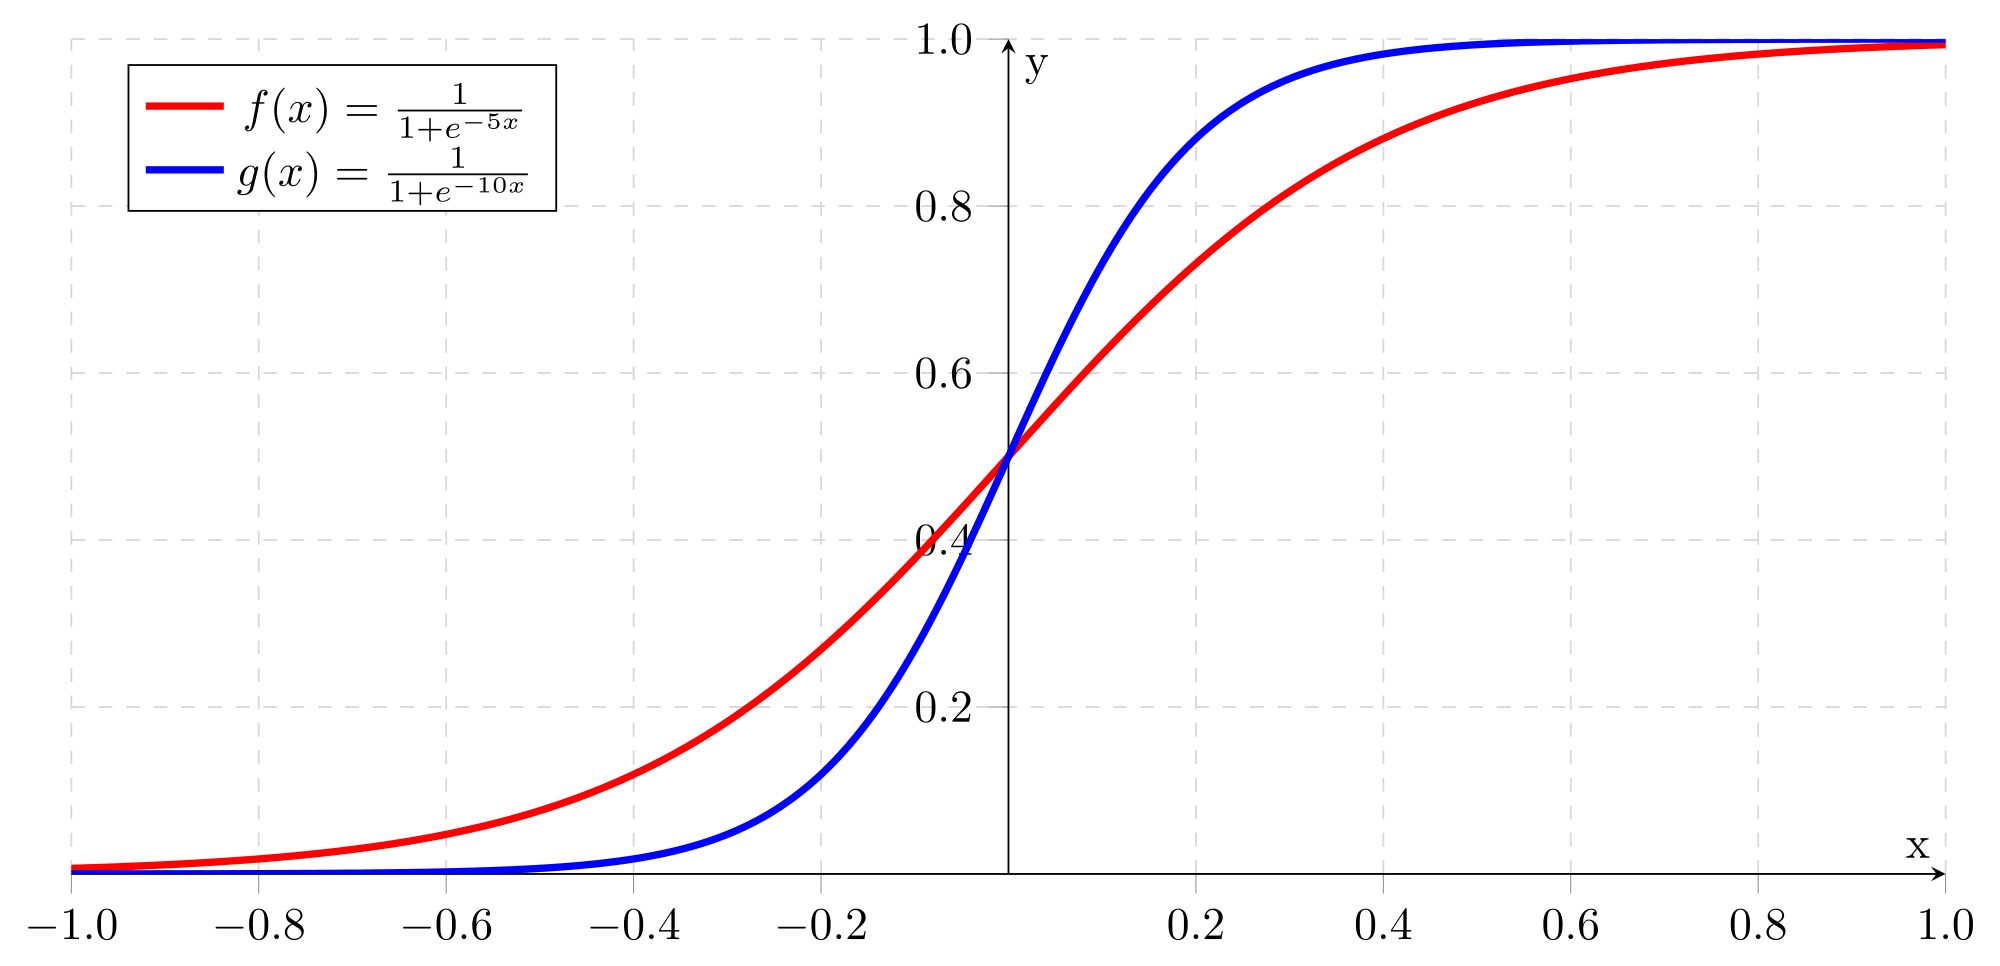

The $a_i, b$ parameters are found by minimizing cross-entropy loss:

$\mathcal{L} = -\Sigma_{i=1}^{N} y_i \log(p_i) + (1-y_i) \log(1-p_i)$

where $y_i$ is the label (either 0 or 1) and $p_i$ is the predicted probability.

Logistic regression is a linear method i.e. the linear combination ensures that the methods looks for a plane (a linear surface) in the n-dimensional feature space to separate class 0 from class 1. In the special case, when there are two input features, x and y, the linear combination:

$a_1 x + a_2 y + b = 0$ 

(such that $\sigma(a_1 x + a_2 y + b) =0.5$)

defines the surface called the **decision boundary** which separates the two classes and it's a straight line in the x-y plane.

We don't expect logistic regression to do very well on the input data with the alternate featurization (using value counts). This is because by featurizing this way, we are imposing additional constraints on the linear model that are not true. As an example, consider a categorical column D that takes two unique values A (60%), B (30%) and C (10%). We are replacing all instances of A by 60%, all of B by 30% and all of C by 10%. So logistic regression will compute $a$ as follows:

D = A: $a_A = b + a_1*0.6$

D = B: $a_B = b + a_1*0.3$

D = C: $a_C = b + a_1*0.1$

If $a_1 > 0$, then we have:

$a_A > a_B > a_C \rightarrow (p_A > p_B > p_C$)

If $a_1 < 0$, then we have:

$a_A < a_B < a_C \rightarrow (p_A < p_B < p_C$)

Either way the fact that we imposed an order on the features for A, B and C, results in logistic regression always obeying the same order for the probabilities. In general though, there are 3! = 6 permutations or possible orderings of these three factors but instead of learning through data, we are forcefully imposing one of two and logistic regression can at most pick one of two permutations by picking the sign of the weight $a_1$.

A solution is to go back to using the 1-hot encoded data here which we leave as an exercise.

In [10]:
#Try a Logistic Regression model

### k-Nearest Neighbors

The idea here is very simple. For each data row, find the k nearest input values (according to some distance metric you choose), and average their labels.

In [11]:
#Try a k-Nearest Neighbor model

So we have two models - using completely different techniques and each gives roughly similar AUCs.

What if we just average their predictions?

In [ ]:
model1_train_pred = model1.predict_proba(train_df)[:, 1]
model1_test_pred = model1.predict_proba(test_df)[:, 1]

model2_train_pred = model2.predict_proba(train_df)[:, 1]
model2_test_pred = model2.predict_proba(test_df)[:, 1]

mean_train_pred = (model1_train_pred + model2_train_pred) / 2.
mean_test_pred = (model1_test_pred + model2_test_pred) / 2.

In [ ]:
train_labels = train['HasDetections']
test_labels = test['HasDetections']

train_score = roc_auc_score(train_labels, mean_train_pred)
test_score = roc_auc_score(test_labels, mean_test_pred)

print(f'train_score = {train_score} : test_score = {test_score}')

### Neural Networks

We won't go into the details of a neural network here (see Sunday's talk for more details) but here's a snippet showing how to use PyTorch to define a neural network.

In [12]:
import torch.nn as nn
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, N_input=79, N_output=1, N_hidden_layers=1, N_hidden_nodes=100):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(N_input, N_hidden_nodes)
        
        self.hidden = nn.ModuleList([])
        for i in range(N_hidden_layers-1):
            self.hidden.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.linear2 = nn.Linear(N_hidden_nodes, N_output)
        
        self.activation = nn.ReLU()
        
        self.output_activation = nn.Sigmoid()
        
    def forward(self, x):
        out = self.activation(self.linear1(x))
        for layer in self.hidden:
            out = self.activation(layer(out))
        out = self.output_activation(self.linear2(out))
        
        return out

### Ensembling: Some general notes

We have built single models in the treatment above. In practice, training multiple models and combining them often leads to significantly better performance. While this sounds mysterious, we did exactly this in random forests. Instead of training one decision tree, we trainined several (10, 100 etc.) and combined the predictions made by each tree (by averaging).

The combination of the predictions of multiple models is called **ensembling**.

A few notes:
1. Ensembling can give significant boosts in the performance metric and is almost always used in the top Kaggle entries.
2. This extra performance comes at the cost of a) increased complexity during training - imagine 30 different models voting to create a single prediction, b) heightened dangers of overfitting - the general philosophy of training each model on a different dataset comes under stress when one is training 10s or 100s of models.
3. Ensembling works best when the underlying models make "different" predictions i.e. they work well in different parts of the input space.

#### Averaging:

This is also often called **bagging** and involves just the following steps:

1. Train N different models. These can use different techniques (Random Forests, k-nearest neighbor, support vector machines, neural networks) or even one technique with randomly initialized parameters (specially with neural networks).

2. Average the predictions of all the models.

There are subtleties when the probabilities aren't calibrated and often the scores are used to rank the predictions and average the ranks.

#### Stacking and Blending:

Note: if you get to this point, please let either of us know and we'll give you an intro to these two ensembling techniques.



### Topics Not Covered (Yet)

1. Details of probability calibration
2. Hyperparameter tuning/scanning
3. Unsupervised techniques to understand data better
4. Exploration of errors (in detail)
5. Ensembling - Stacking and Blending